# Explainer of bioage acceleration

In [1]:
from bioage_tools import AccModel, AccModelExplainer

### Prepare bioage model example and data

Prepare simple dataset

In [2]:
import numpy as np

num_samples = 1000
num_features = 10
np.random.seed(44)
X = np.random.uniform(size=(num_samples, num_features))
coefs = np.random.uniform(size=(num_features))
eps = np.random.normal(0, 0.5, size=(num_samples))
ages = (X @ coefs) * 20 + eps * 3

Data should be saved as dataframe

In [3]:
import pandas as pd
df_X = pd.DataFrame(X)
ages = pd.Series(ages, name='age')

Prepare simple model 

In [4]:
from sklearn.linear_model import LinearRegression

bioage_model = LinearRegression()
bioage_model.fit(X, ages)

bioage_model.score(X, ages)

0.9821976415356001

### Prepare bioage model with accelerations

We use method `AccModel.fit()` to train:
- bias correction (`bias_correction=True`) 
- and model itself if needed (`need_fit=True`) 

In [5]:
bioage_acc_model = AccModel(bioage_model, need_fit=False, bias_correction=True)
bioage_acc_model.fit(df_X, ages);

Normal prediction of bioage with bias correction if opted in constructor

In [6]:
bioage = bioage_acc_model.predict(X)

In [7]:
bioage

array([59.22278584, 76.35163886, 56.03486258, 52.82093066, 80.39725513,
       52.02229474, 50.93086534, 68.81750533, 38.51745984, 52.72240009,
       42.3137429 , 45.81825162, 53.86846254, 67.65207032, 75.02882222,
       61.02359449, 54.22268427, 66.19919596, 65.39546977, 52.06999446,
       43.12790711, 57.17746389, 74.31691698, 58.09211176, 58.01950103,
       66.19393973, 62.11877923, 58.70692524, 51.03097807, 49.87973457,
       85.51838179, 50.49211524, 54.18142128, 29.0261871 , 56.21603477,
       65.51525816, 61.69719192, 54.15282682, 66.61860046, 61.1284013 ,
       37.46288921, 53.6655635 , 79.77384015, 83.65546157, 55.08354742,
       60.77348722, 51.26252097, 57.19114066, 51.77699296, 43.39534514,
       63.78883288, 67.03756791, 65.85232634, 45.321109  , 58.00405239,
       92.12164997, 42.30791233, 77.6917548 , 59.62066901, 33.53922068,
       63.08249203, 68.1824827 , 80.37369143, 58.29250675, 32.72685466,
       61.75130266, 66.15659535, 65.86586828, 53.59313284, 55.42

Compute bioage accelerations as residuals

In [8]:
acc = bioage_acc_model.predictacc(X, ages)

In [9]:
acc

array([-8.44066936e-01,  1.39596211e+00, -1.56811200e-01,  2.54347754e-02,
       -1.27877095e-01,  3.93329231e-01,  1.74570965e+00,  2.51516330e-02,
        5.19452049e-01,  2.60801912e+00,  8.88872681e-01, -9.47778611e-01,
        2.00774363e+00, -1.36688565e+00, -2.69952102e+00, -1.58116599e+00,
        1.72916780e-01, -1.06045928e+00, -8.08263184e-01, -4.25921533e+00,
       -3.35671552e+00,  1.83480759e+00, -1.28780096e+00, -2.20597465e+00,
        8.80139477e-01, -3.24163521e+00, -1.42270860e+00,  2.47886580e+00,
       -1.39178035e-01, -2.28466900e+00,  4.03533025e+00, -1.88140125e+00,
       -1.52941997e+00, -1.44964584e-01, -1.96751693e+00,  2.47226883e-01,
        2.84028266e+00, -7.73126953e-01,  1.11939084e+00, -1.55064892e+00,
        5.29706911e-01, -5.14708683e-02, -2.09036078e+00,  2.23401208e+00,
       -1.13501570e+00, -1.95127754e-01, -2.30049081e-01,  1.09244670e+00,
       -1.34739890e+00, -1.51185941e+00,  7.72989091e-01,  4.92333123e-01,
       -1.54650044e+00,  

Visualization of pairwise plot bioage vs age. 

Points with visualized accelerations are generated by chance.

Gray line is a regression line fitted on train.

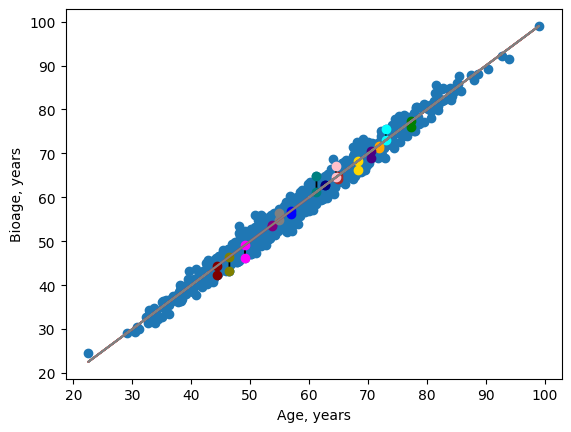

In [10]:
bioage_acc_model.plot_predict(X, ages, seed=42)

## Explanation of accelerations

Same acc model with possibility of explanations. 

Previous step of creating AccModel can be skipped.

In [11]:
from bioage_tools import AccModelExplainer

!!!! `df_x` must strictly consists only out of used features by the model. !!!!

All unused features for the model should be dropped.

In [12]:
bioage_acc_model = AccModelExplainer(bioage_model, need_fit=False, bias_correction=True)
bioage_acc_model.fit(df_X, ages);

Build SHAP Explainer for accelerations

In [13]:
from shap import Explainer

acc_explainer: Explainer = bioage_acc_model.make_shap_explainer_acc(
    df_X.join(ages), acc_masker_config={
        "min_num_closest_samples": 5, 
        "delta_age": 5,
        "max_num_closest_samples": 250,
        "algo": 'age_vs_ages'
    }
)

Explanation for person can be done only if enough persons with the same age.

- `min_num_closest_samples` - defines this threshold: minimum number of persons with the same age.
- `delta_age` - defines "the same age", i.e. is the person age +- `delta_age`.
- `max_num_closest_samples` - defines maximum number of samples for background (can be set any positive number, but in fact it will be not higher than number of people in the age range defined by `delta_age`). This parameter can help to reduce unnecessary computations due to SHAP values looks the same.
- `algo` - can be `'age_vs_ages'` to compare age of person with ages of persons in the background.
or it can be `'age_vs_cages'` to compare age of person with the bioage of persons in the background.

In [14]:
np.histogram(ages)

(array([  2,  35, 100, 195, 270, 215, 116,  48,  16,   3]),
 array([22.52064117, 30.17043619, 37.82023121, 45.47002622, 53.11982124,
        60.76961626, 68.41941127, 76.06920629, 83.71900131, 91.36879632,
        99.01859134]))

So we should choose only ages where is enough persons

In [15]:
age_mask = (ages > 30) & (ages < 90)

Next, run explainer. By default we use Permutation algorithm. Not tested with other algorithms

In [16]:
shap_values_acc, shap_values_acc_2 = acc_explainer(
    df_X.loc[age_mask], pd.DataFrame(ages.loc[age_mask])
)

PermutationExplainer explainer: 995it [00:52, 15.90it/s]                         


In [17]:
shap_values_acc

.values =
array([[ 5.64969245, -6.35037326,  4.11126488, ..., -0.89842718,
        -0.15624128,  0.48840103],
       [ 4.37657537, -2.34955453, -4.93525443, ...,  2.88945322,
         0.53026863, -0.7745231 ],
       [ 2.5910791 , -5.25957039, -0.43882484, ..., -3.40232181,
         0.86808567, -0.74659783],
       ...,
       [ 5.47142984,  6.59775595, -9.40059204, ..., -2.23000128,
        -1.99036962, -0.22093807],
       [-3.11659796, -3.21293676, -2.0749839 , ...,  1.2214184 ,
         4.77708009,  0.62616396],
       [ 4.15700386,  0.58082531,  5.52060704, ...,  2.29382207,
        -4.09469446, -0.41391845]])

.base_values =
array([-3.33974279e-02,  3.25287642e-02,  1.16902090e-02,  6.62384784e-02,
        5.77171102e-02,  1.19945060e-01,  5.27183734e-02,  4.29004137e-02,
       -5.07379783e-02,  8.16668827e-02, -5.07379783e-02,  1.01901503e-01,
        1.06203323e-01,  2.54165692e-03,  6.18094234e-02, -4.51888090e-02,
        5.11299359e-02, -7.43408059e-02, -8.79270258e-02,  3.

In [18]:
shap_values_acc_2

.values =
array([], shape=(994, 0), dtype=float64)

.base_values =
array([-3.33974279e-02,  3.25287642e-02,  1.16902090e-02,  6.62384784e-02,
        5.77171102e-02,  1.19945060e-01,  5.27183734e-02,  4.29004137e-02,
       -5.07379783e-02,  8.16668827e-02, -5.07379783e-02,  1.01901503e-01,
        1.06203323e-01,  2.54165692e-03,  6.18094234e-02, -4.51888090e-02,
        5.11299359e-02, -7.43408059e-02, -8.79270258e-02,  3.84403621e-02,
        1.10498725e-01,  1.89603488e-04,  3.12602213e-03, -1.98275759e-02,
        3.99728717e-02,  4.50422609e-03, -8.28004263e-02,  8.49730600e-03,
        8.69807889e-02,  1.07931930e-01, -7.05162925e-02,  1.30067091e-01,
        1.61444373e-03,  3.33302211e-02, -5.80851498e-02, -4.34943761e-02,
        5.55823460e-02, -5.54946761e-02, -5.02054467e-02, -5.07379783e-02,
        3.39701160e-02, -8.55386998e-02, -7.05162925e-02,  8.49730600e-03,
       -1.77827710e-03,  1.17013479e-01,  1.04563060e-02,  8.41362263e-02,
       -2.78902759e-03, -7.750044

## Save/load resulting Explainer

In [19]:
with open('explainer.pkl', 'wb') as fout:
    acc_explainer.save(fout)

In [20]:
from shap import Explainer
from bioage_tools import AccMasker
with open('explainer.pkl', 'rb') as fin:
    explainer_loaded = Explainer.load(fin, masker_loader=AccMasker.load)

In [21]:
loaded_shap_values_acc, loaded_shap_values_acc_2 = explainer_loaded(
    df_X.loc[age_mask], pd.DataFrame(ages.loc[age_mask])
)

PermutationExplainer explainer: 995it [00:52, 15.11it/s]                         


In [22]:
np.allclose(loaded_shap_values_acc.values, shap_values_acc.values)

True

In [23]:
np.allclose(loaded_shap_values_acc.base_values, shap_values_acc.base_values)

True

In [24]:
np.allclose(loaded_shap_values_acc.data, shap_values_acc.data)

True